<a href="https://colab.research.google.com/github/rashidmeras/EVA_PHASE1/blob/master/Assignment10/EVA_S10_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EVA Session10 Assignment - Objective: 

*   Describes the sequence for running a **Gradient-weighted Class Activation Mapping (GradCAM)** on an image to find an object (sunglasses) with class ID:837



# API imports and basic setup

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras import backend as K
from skimage import io
from google.colab.patches import cv2_imshow

import numpy as np
import cv2

Using TensorFlow backend.


# Mount Google drive to import the test image

In [0]:
!pip install pydrive


from google.colab import drive
drive.mount('/content/gdrive')

     |████████████████████████████████| 993kB 2.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# 1. Load the VGG model



In [0]:
model = VGG16(weights="imagenet")

# print([layer.name for layer in model.layers[0:] if "conv" in layer.name])
i=0
for layer in model.layers[0:]:
  if "conv" in layer.name:
    print ("Layer No.:", i, " Name:", layer.name)
    i+=1

W0713 18:04:53.314829 139655828350848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0713 18:04:53.362727 139655828350848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0713 18:04:53.374936 139655828350848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0713 18:04:53.432823 139655828350848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



553467904/553467096 [==============================] - 5s 0us/step


W0713 18:05:00.034544 139655828350848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0713 18:05:00.035916 139655828350848 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



Layer No.: 0  Name: block1_conv1
Layer No.: 1  Name: block1_conv2
Layer No.: 2  Name: block2_conv1
Layer No.: 3  Name: block2_conv2
Layer No.: 4  Name: block3_conv1
Layer No.: 5  Name: block3_conv2
Layer No.: 6  Name: block3_conv3
Layer No.: 7  Name: block4_conv1
Layer No.: 8  Name: block4_conv2
Layer No.: 9  Name: block4_conv3
Layer No.: 10  Name: block5_conv1
Layer No.: 11  Name: block5_conv2
Layer No.: 12  Name: block5_conv3


# 2. Load the image and processing

In [0]:
tony_stark = io.imread('/content/gdrive/My Drive/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg')

## 2.1 Rescale image to 224x224x3 and display

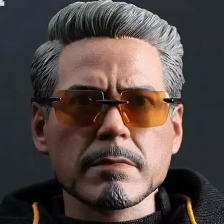

In [0]:
tony_stark = cv2.resize(tony_stark, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
cv2_imshow(cv2.cvtColor(tony_stark, cv2.COLOR_BGR2RGB))

## 2.2 Use expand_dims to convert image to a batch of size 1

In [0]:
x = image.img_to_array(tony_stark)
x = np.expand_dims(x, axis=0)

## 2.3 Preprocesing: Normalizes the input image by subtracting mean RGB values

In [0]:
x = preprocess_input(x)

# 3. Run through the network and get the predictions


In [0]:
preds = model.predict(x)

# 4. Compute the value of the class activation for the class with ID 837

*   The **class_idx: 837** corresponds to label: *sunglasses*
*   Take the topmost class index
*   Take output from the final convolutional layer

In [0]:
class_idx = np.argmax(preds[0])
print(class_idx)
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("block5_conv3")

837


# 5. Compute the gradient of the class output value w.r.t the feature map

*   Pool the gradients over all the axies leaving out the channel dimension
*   Weigh the output feature map with the computed gradient values



In [0]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
print(grads.shape)

pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads.shape)

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
  conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

(?, 14, 14, 512)
(512,)


# 6. Average the weighted feature map along the channel dimension 

*   This results in a heat map of size 14x14
*   Normalize the heat map to make the values between 0 and 1

In [0]:
heatmap = np.mean(conv_layer_output_value, axis = -1)
print(conv_layer_output_value.shape)
print(heatmap.shape)

# Normalize
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

heatmap = cv2.resize(heatmap, (tony_stark.shape[1], tony_stark.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

(14, 14, 512)
(14, 14)


# 7. Overlay on top of the image

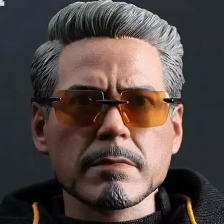

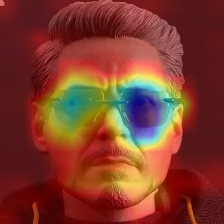

In [0]:
superimposed_img = cv2.addWeighted(tony_stark, 0.5, heatmap, 0.5, 0)

cv2_imshow(cv2.cvtColor(tony_stark, cv2.COLOR_BGR2RGB))
cv2_imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))

# Summary:


*   Successfully defined the sequence for running a GradCAM on an image to find an object (sunglasses) with class ID:837



# Reference:
1. [EVA Session 10](https://canvas.instructure.com/courses/1587436/assignments/11648678?module_item_id=24152260)
2. [Playing with kernels and activations - COLAB File](https://colab.research.google.com/drive/10GugXUNI7ztK2joRZUnYyqRrQbYnOQE0)

